In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

from pathlib import Path

import motorlab as ml
import numpy as np
import seaborn as sns
import yaml

In [ ]:
os.chdir(Path().resolve().parent)

In [ ]:
runs_coordinates = {
    "allocentric": 20250820181501,
    "centered": 20250820220905,
    "egocentric": 20250820232743,
}

### pcs to exclude

In [ ]:
# obtained in the notebook 'analysis_pca.ipynb'

# delete pcs that are >= 0.15 above baseline.
with open("artifacts/tables/analysis_pca/loose.yml", "r") as f:
    loose = yaml.safe_load(f)

# delete pcs that are >= 0.10 above baseline.
with open("artifacts/tables/analysis_pca/medium.yml", "r") as f:
    medium = yaml.safe_load(f)

# delete pcs that are >= 0.05 above baseline.
with open("artifacts/tables/analysis_pca/strict.yml", "r") as f:
    strict = yaml.safe_load(f)

# delete pcs that are >= 0.01 above baseline.
with open("artifacts/tables/analysis_pca/draconian.yml", "r") as f:
    draconian = yaml.safe_load(f)

### training

In [ ]:
experiment = "gbyk"
sessions = ml.sessions.OLD_GBYK
config = ml.config.get_default_config(experiment, sessions)
config["CHECKPOINT_DIR"] = "checkpoint/poses_to_spike_count"
config["CONFIG_DIR"] = "config/poses_to_spike_count"
config["in_modalities"] = "poses"
config["out_modalities"] = "spike_count"
config["loss_fn"] = "poisson"
config["metric"] = "correlation"

config["intervals"]["include_homing"] = True
# config["train"]["lr"] = 3e-4

config["model"]["architecture"] = "fc"
config["model"]["n_layers"] = 1
config["model"]["embedding_dim"] = 256
config["model"]["hidden_dim"] = 512
config["model"]["readout"] = "softplus"

# config["dataset"]["seq_length"] = 20
# config["dataset"]["stride"] = 20

config["spikes"]["brain_area"] = "all"

config["poses"]["representation"] = "allocentric"
config["poses"]["project_to_pca"] = True
# config["poses"]["pcs_to_exclude"] = draconian

ml.model.train(config)

FCModel(
  (embedding): LinearEmbedding(
    (linear): ModuleDict(
      (bex_20230621_spikes_sorted_SES): Linear(in_features=66, out_features=256, bias=True)
      (bex_20230624_spikes_sorted_SES): Linear(in_features=66, out_features=256, bias=True)
      (bex_20230629_spikes_sorted_SES): Linear(in_features=66, out_features=256, bias=True)
      (bex_20230630_spikes_sorted_SES): Linear(in_features=66, out_features=256, bias=True)
      (bex_20230701_spikes_sorted_SES): Linear(in_features=66, out_features=256, bias=True)
      (bex_20230708_spikes_sorted_SES): Linear(in_features=66, out_features=256, bias=True)
      (ken_20230618_spikes_sorted_SES): Linear(in_features=66, out_features=256, bias=True)
      (ken_20230622_spikes_sorted_SES): Linear(in_features=66, out_features=256, bias=True)
      (ken_20230629_spikes_sorted_SES): Linear(in_features=66, out_features=256, bias=True)
      (ken_20230630_spikes_sorted_SES): Linear(in_features=66, out_features=256, bias=True)
      (ken_20

/Users/caio/dev/motorlab/motorlab/metrics.py:99: RuntimeWarning: invalid value encountered in divide
  corr = numerator / denom


epoch: 0001 | local correlation: -0.0003 | global correlation: -0.0020
epoch: 0001 | loss: 1.5878 | grad_norm: 0.12031532 | local correlation: 0.0256 | global correlation: 0.0620
epoch: 0002 | loss: 1.4411 | grad_norm: 0.09945608 | local correlation: 0.0583 | global correlation: 0.1643
epoch: 0003 | loss: 1.4294 | grad_norm: 0.10474454 | local correlation: 0.0841 | global correlation: 0.2006
epoch: 0004 | loss: 1.4215 | grad_norm: 0.10716638 | local correlation: 0.1047 | global correlation: 0.2247
epoch: 0005 | loss: 1.4156 | grad_norm: 0.10740619 | local correlation: 0.1200 | global correlation: 0.2421
epoch: 0006 | loss: 1.4109 | grad_norm: 0.11637986 | local correlation: 0.1311 | global correlation: 0.2551
epoch: 0007 | loss: 1.4065 | grad_norm: 0.11746349 | local correlation: 0.1394 | global correlation: 0.2668
epoch: 0008 | loss: 1.4029 | grad_norm: 0.12641103 | local correlation: 0.1460 | global correlation: 0.2761
epoch: 0009 | loss: 1.3999 | grad_norm: 0.13496158 | local correl

### eval

In [ ]:
# ken_20230614
# run = None  # spike sorted: false

In [ ]:
# egocentric representation
run = 20250625104007  # homing: false
run = 20250625113801  # homing: true

In [ ]:
# run = None  # representation: egocentric
# run = None  # representation: centered
# run = None  # representation: allocentric

In [ ]:
run = 20250717110536  # allocentric, project to pca
run = 20250717002546  # egocentric, project to pca
run = 20250716222138  # draconian

In [ ]:
config_path = Path(f"config/poses_to_spike_count/{run}.yml")

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

eval_metrics, eval_gts, eval_preds = ml.model.evaluate(config)

In [ ]:
global_corr = ml.metrics.global_correlation(eval_gts, eval_preds)
local_corr = ml.metrics.local_correlation(eval_gts, eval_preds)

In [ ]:
areas = dict()
for session in sessions:
    areas[session] = np.load(
        Path(
            f"{config['data_dir']}/{config['experiment']}/{session}/spike_count/meta/areas.npy"
        )
    )
    areas[session] = np.where(
        np.char.startswith(areas[session], "M1"), "M1", areas[session]
    )
    areas[session] = np.where(
        np.char.startswith(areas[session], "PMd"), "PMd", areas[session]
    )

In [ ]:
results = {"session": [], "area": [], "global_corr": [], "local_corr": []}
for session in sessions:
    results["session"].extend([session] * len(global_corr[session]))
    results["area"].extend(areas[session])
    results["global_corr"].extend(global_corr[session])
    results["local_corr"].extend(local_corr[session])

In [ ]:
sns.catplot(
    data=results,
    hue="area",
    y="global_corr",
    col="session",
    kind="box",
    col_wrap=3,
)

In [ ]:
sns.catplot(
    data=results,
    hue="area",
    y="local_corr",
    col="session",
    kind="box",
    col_wrap=3,
)

In [ ]:
results = {
    "session": [],
    "area": [],
    "global_corr": [],
    "local_corr": [],
    "method": [],
}
runs = {
    "20250717002546": "normal ego",
    "20250716222138": "draconian",
    "20250717110536": "normal allo",
}

for run, method in runs.items():
    config_path = Path(f"config/poses_to_spike_count/{run}.yml")

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    eval_metrics, eval_gts, eval_preds = ml.model.evaluate(config)

    global_corr = ml.metrics.global_correlation(eval_gts, eval_preds)
    local_corr = ml.metrics.local_correlation(eval_gts, eval_preds)

    for session in sessions:
        areas = np.load(
            Path(
                f"{config['data_dir']}/{config['experiment']}/{session}/spike_count/meta/areas.npy"
            )
        )
        areas = np.where(np.char.startswith(areas, "M1"), "M1", areas)
        areas = np.where(np.char.startswith(areas, "PMd"), "PMd", areas)
        results["session"].extend([session] * len(global_corr[session]))
        results["area"].extend(areas)
        results["global_corr"].extend(global_corr[session])
        results["local_corr"].extend(local_corr[session])
        results["method"].extend([method] * len(global_corr[session]))

/Users/caio/dev/motorlab/motorlab/metrics.py:99: RuntimeWarning: invalid value encountered in divide
  corr = numerator / denom
/Users/caio/dev/motorlab/motorlab/metrics.py:99: RuntimeWarning: invalid value encountered in divide
  corr = numerator / denom
/Users/caio/dev/motorlab/motorlab/metrics.py:99: RuntimeWarning: invalid value encountered in divide
  corr = numerator / denom


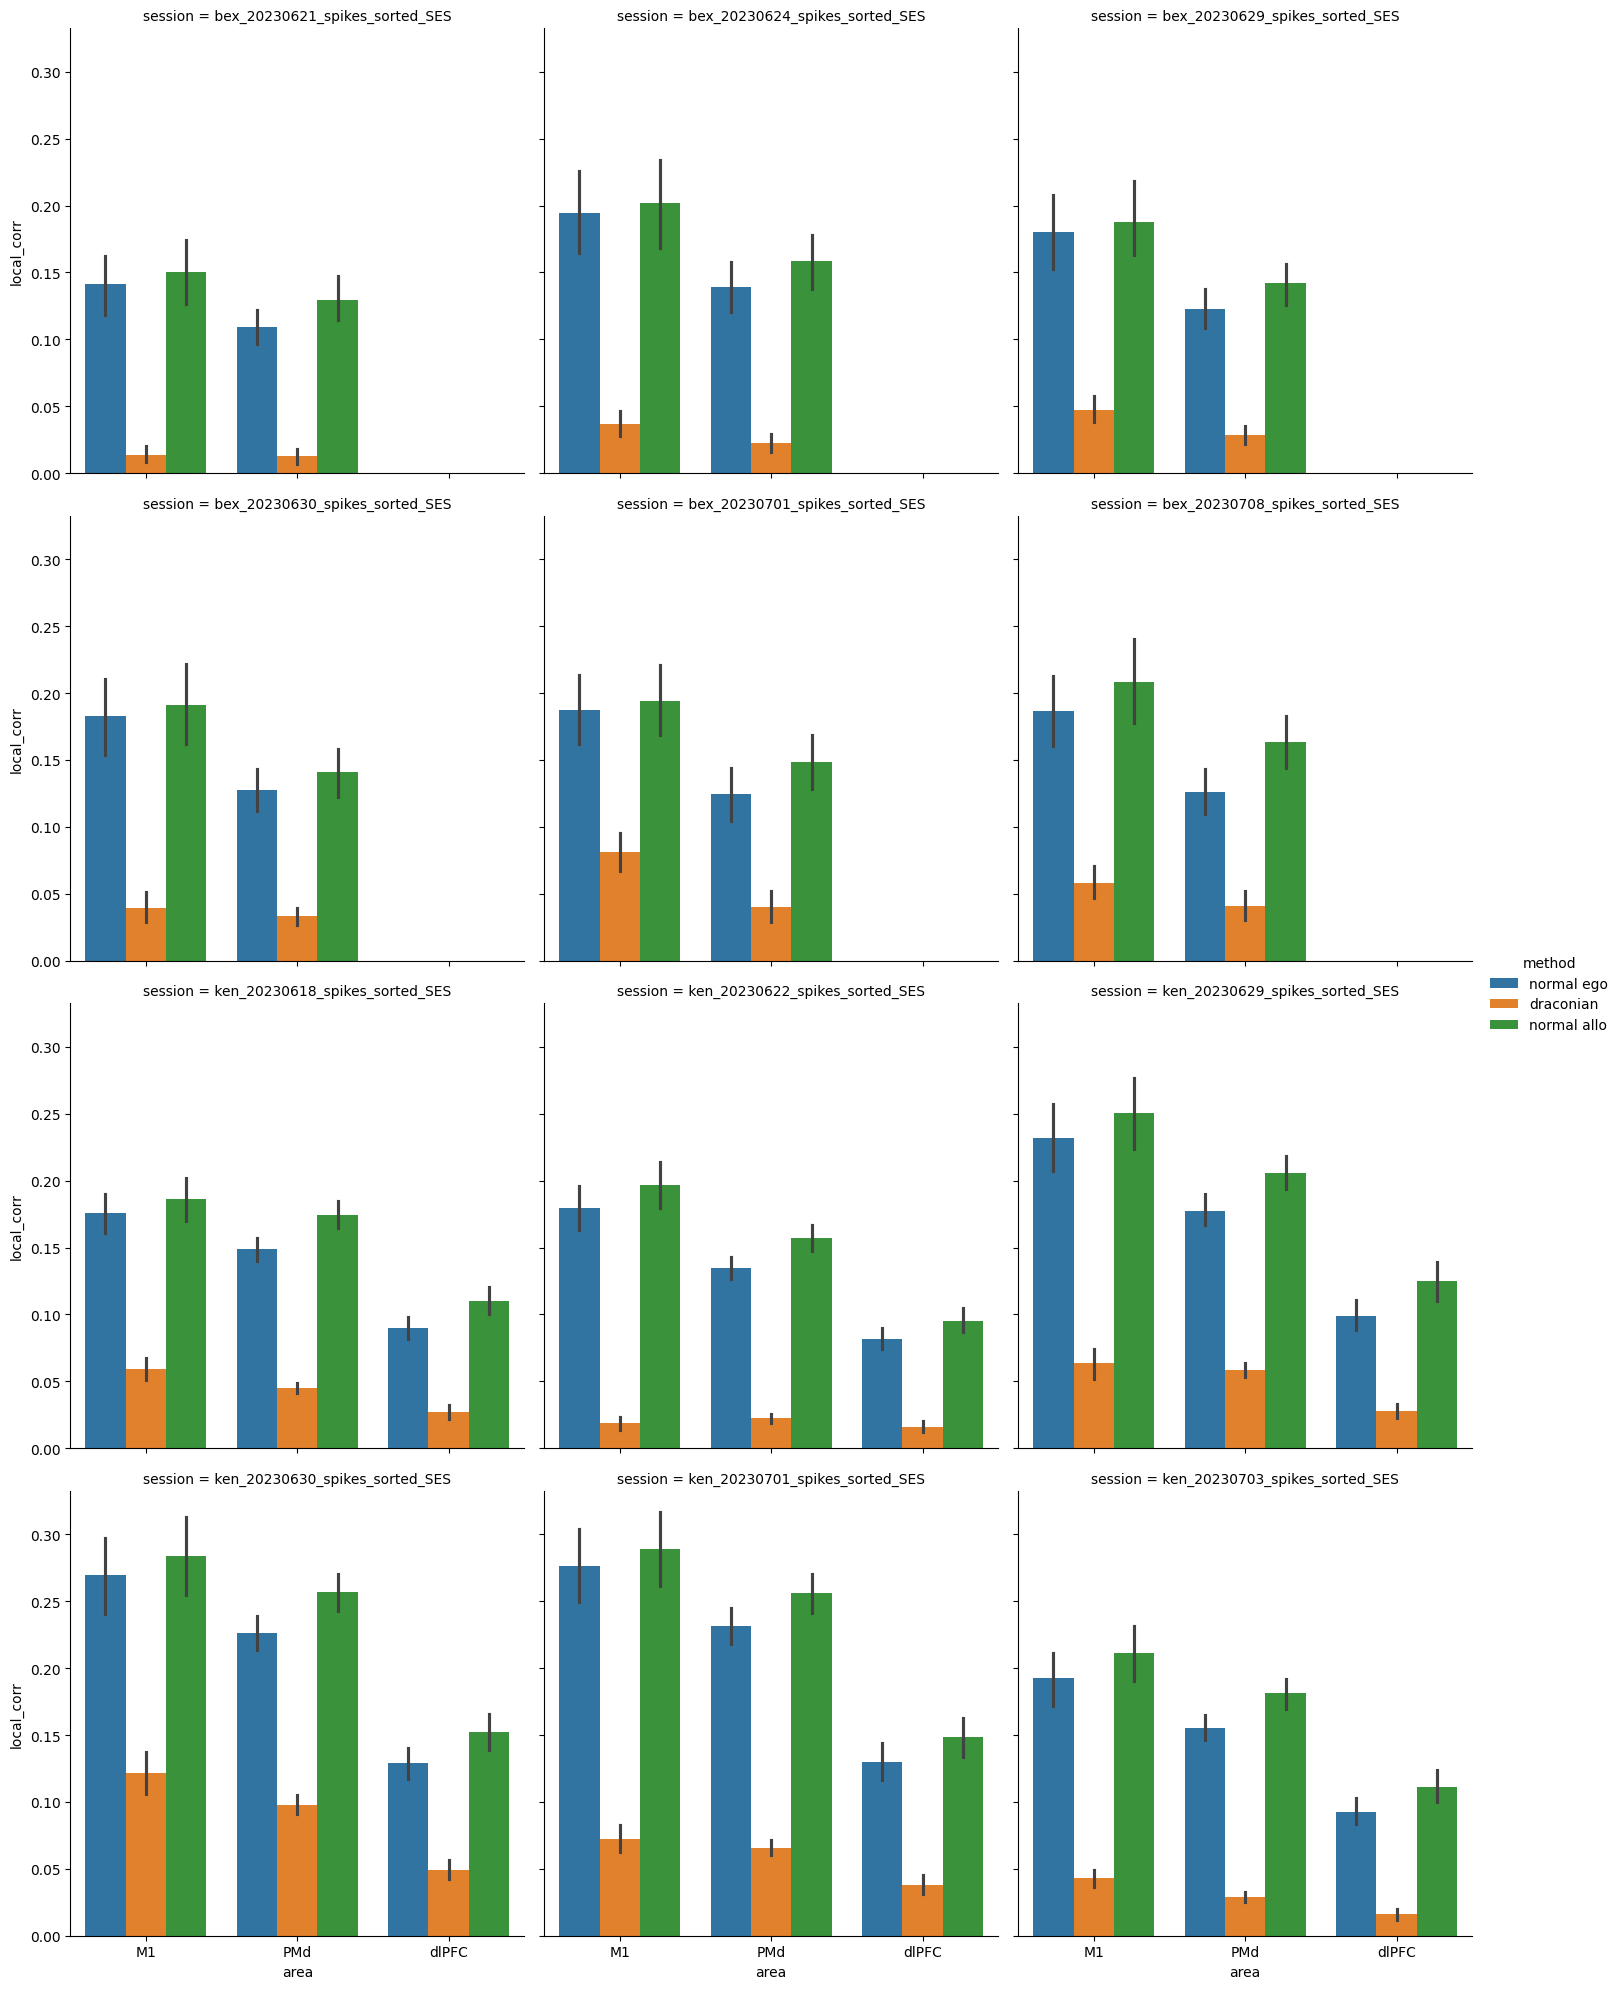

In [ ]:
sns.catplot(
    data=results,
    x="area",
    hue="method",
    y="local_corr",
    col="session",
    kind="bar",
    col_wrap=3,
)

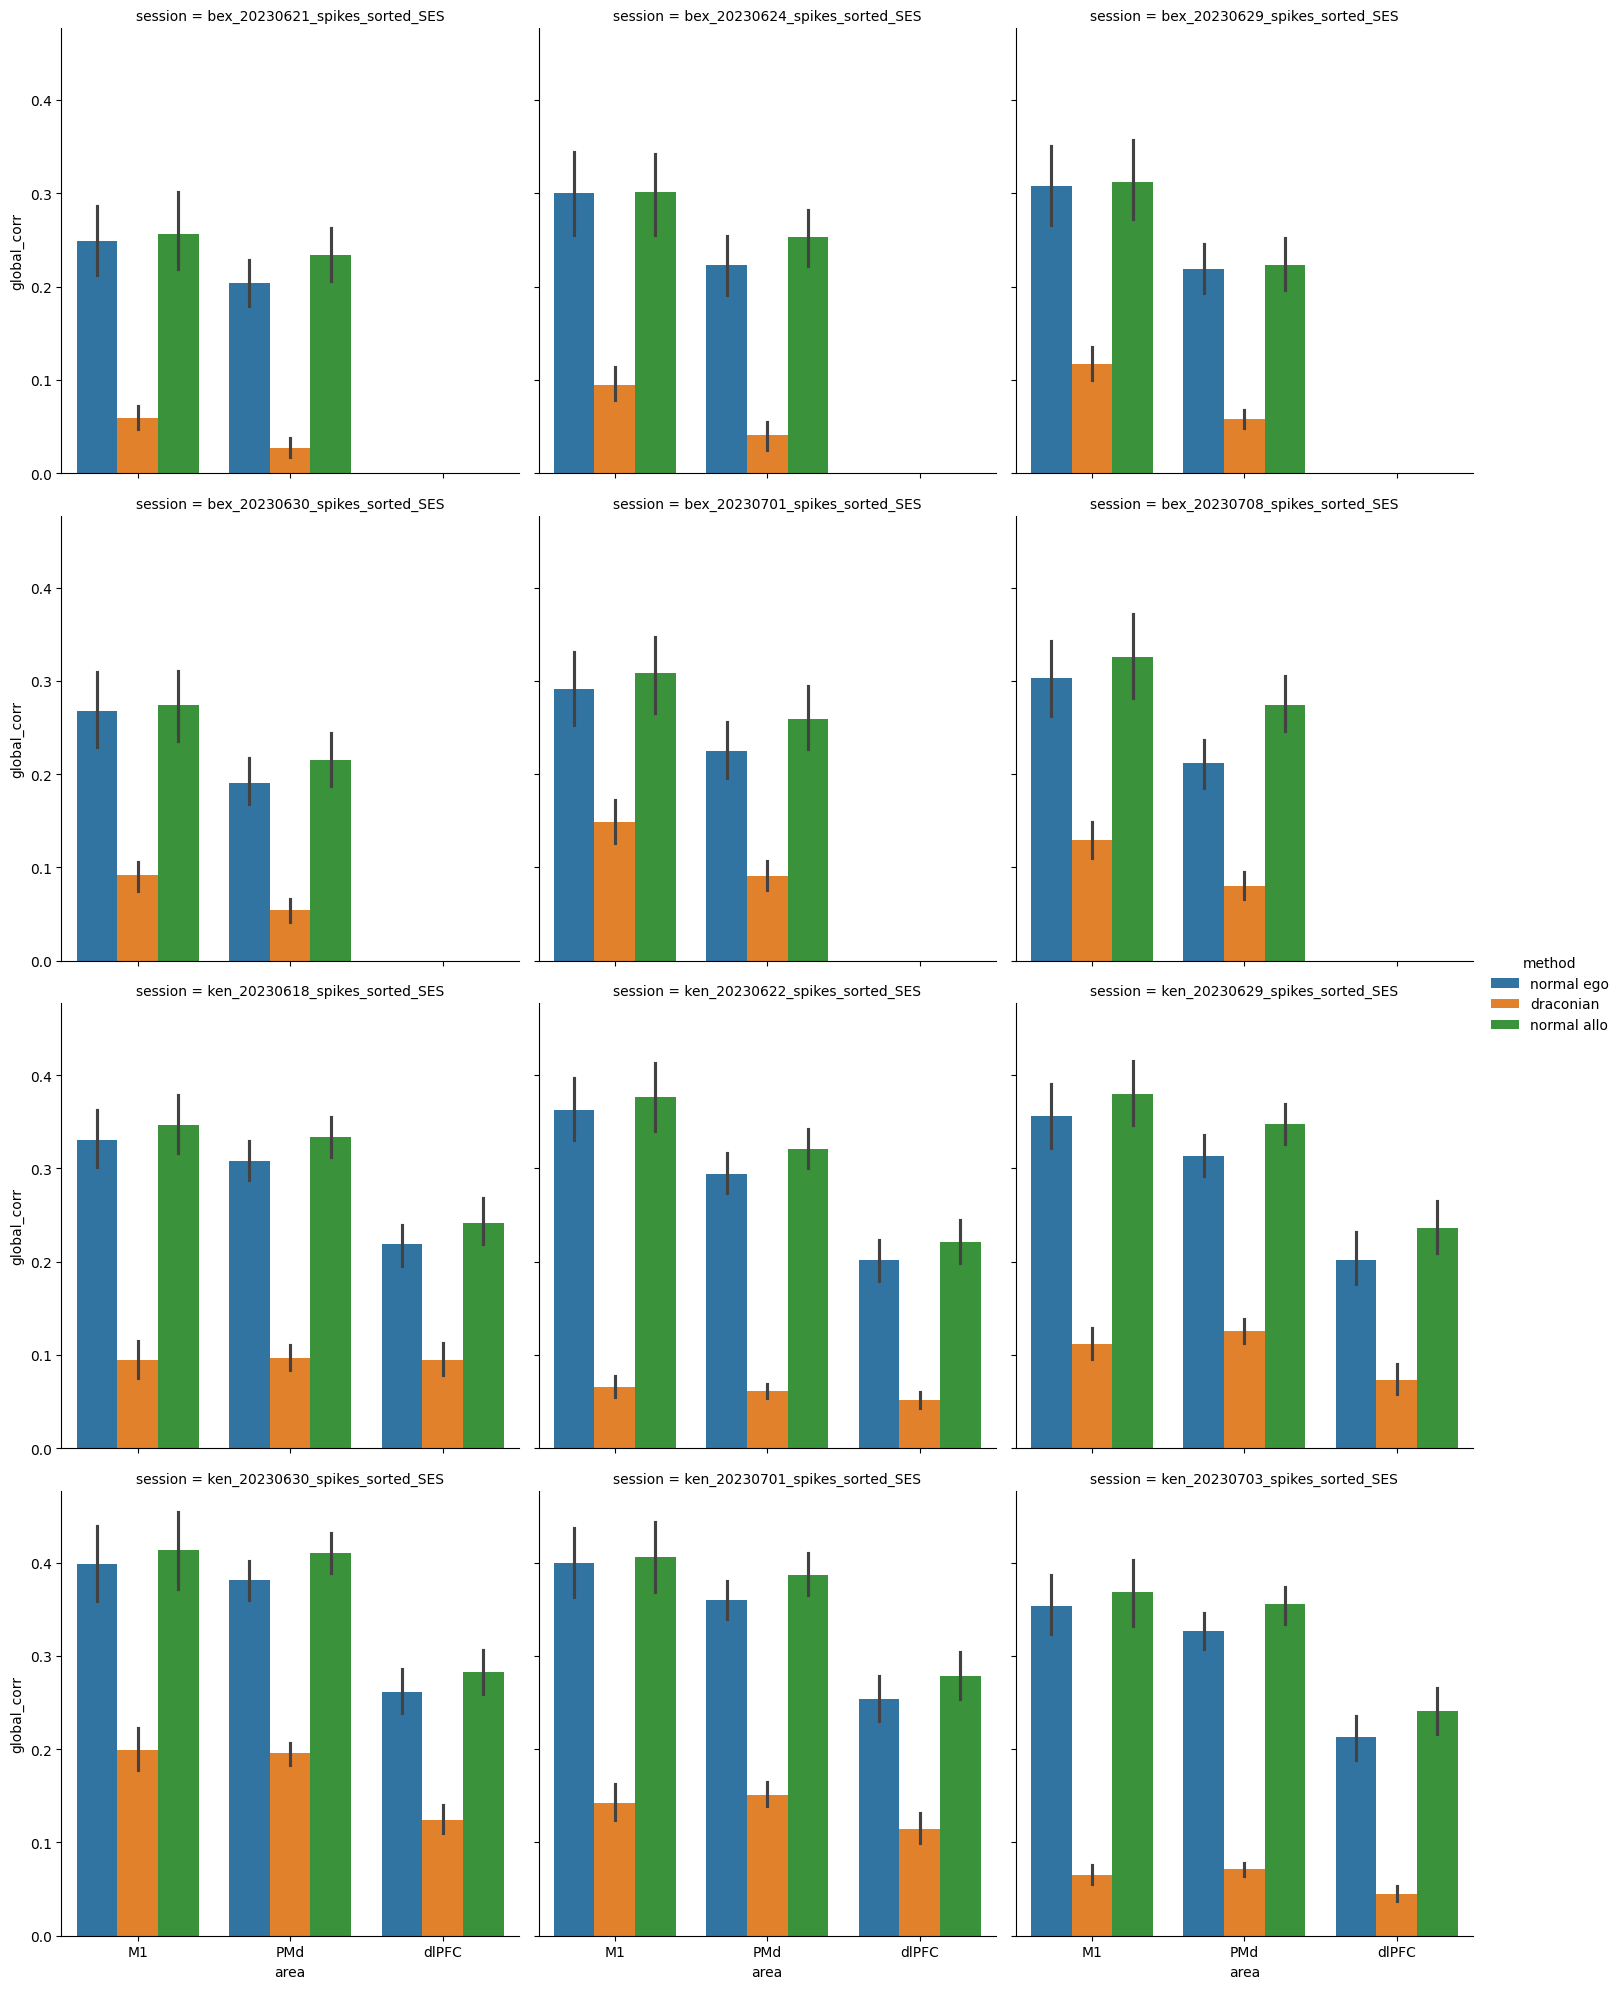

In [38]:
sns.catplot(
    data=results,
    x="area",
    hue="method",
    y="global_corr",
    col="session",
    kind="bar",
    col_wrap=3,
)